In [ ]:

!git clone https://github.com/kuty007/KernelGAN.git

Cloning into 'KernelGAN'...
remote: Enumerating objects: 357, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 357 (delta 62), reused 97 (delta 55), pack-reused 252 (from 1)
Receiving objects: 100% (357/357), 1.05 MiB | 19.57 MiB/s, done.
Resolving deltas: 100% (221/221), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install SAM and necessary dependencies
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision
# Install YOLO and necessary dependencies
!pip install ultralytics


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 765.5/765.5 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.8 MB/s eta 0:00:00
   ━━━━━━━━━

In [ ]:
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import supervision as sv
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import ultralytics
from ultralytics import YOLO

torch.cuda.is_available()
ultralytics.checks()

Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.3/112.6 GB disk)


In [ ]:
# CHECKPOINT downloading
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2025-04-28 05:55:44--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.111, 13.226.210.25, 13.226.210.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   187MB/s    in 15s     

2025-04-28 05:55:59 (163 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
# Define model type and checkpoint path
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "/content/sam_vit_h_4b8939.pth"

# Load the model
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Init sam predictor
predictor = SamPredictor(sam)

# Init YOLO
yolo = YOLO('/content/yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 115MB/s]


MyDrive 안 KernelGAN-Masks 폴더를 생성하고,
그 안에 imgs, masks 폴더 생성

img136 파일 안에 저해상도 사진 1개, 고해상도 사진 1개 업로드
- ex) 고해상도 _ 새 _ lr.png & 저해상도_ 새 _lr.png

Processing image: /content/drive/MyDrive/KernelGAN-Masks/imgs/img136

image 1/1 /content/drive/MyDrive/KernelGAN-Masks/imgs/img136/고해상도_새_lr.png: 640x640 1 bird, 8.0ms
Speed: 16.4ms preprocess, 8.0ms inference, 317.2ms postprocess per image at shape (1, 3, 640, 640)
lr_back shape: (311, 305)
lr_back dtype: uint8
(622, 610)
(311, 305)
(622, 610)
(311, 305)
/content/drive/MyDrive/KernelGAN-Masks/masks/img136/back_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img136/back_lr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img136/obj_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img136/obj_lr_mask.png


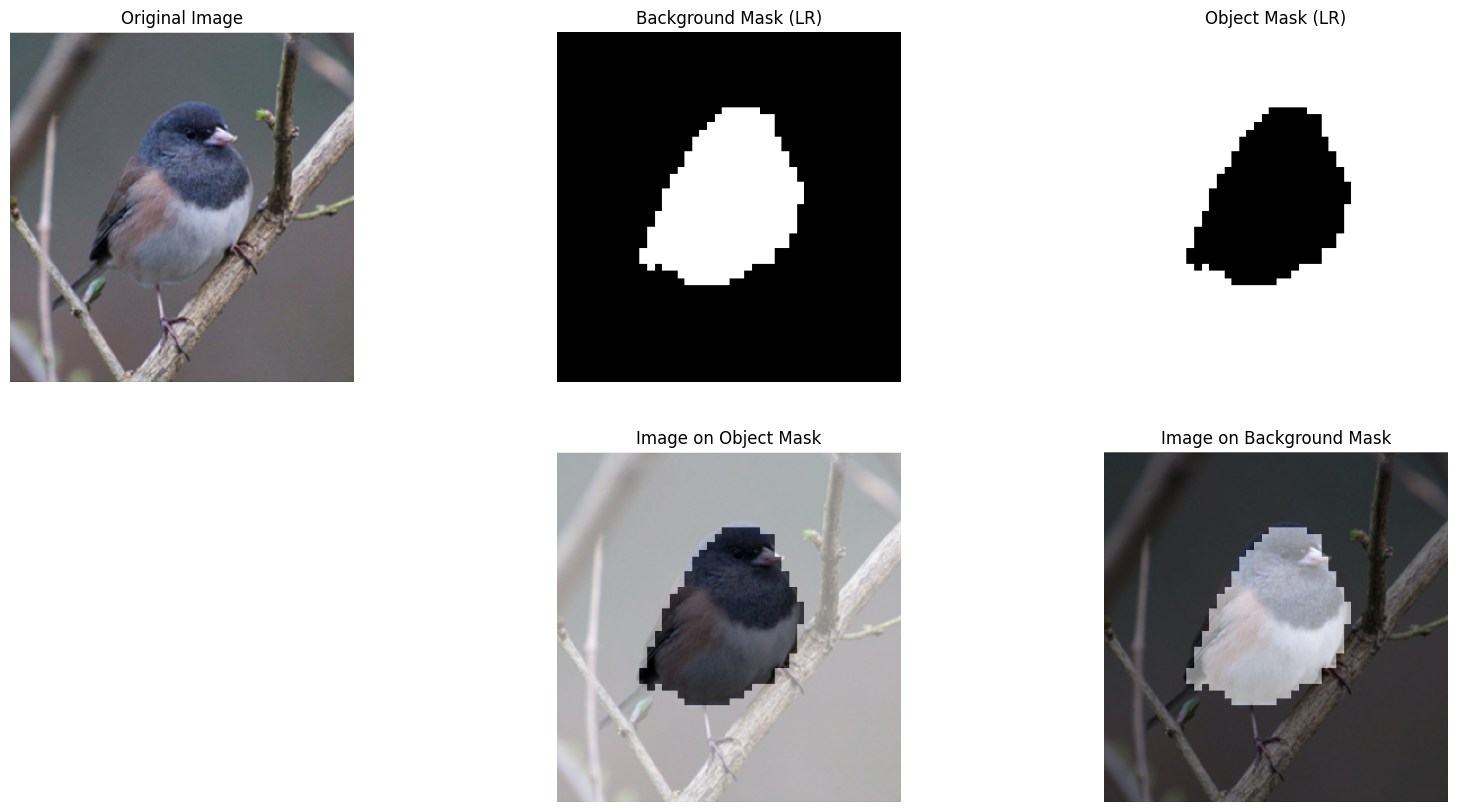

Processing image: /content/drive/MyDrive/KernelGAN-Masks/imgs/.ipynb_checkpoints
No low-resolution image found in /content/drive/MyDrive/KernelGAN-Masks/imgs/.ipynb_checkpoints


In [ ]:
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt

def create_blocky_mask(img):
    scale_factor = 0.15
    _, binary_mask = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    small_lr_back = cv2.resize(binary_mask, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_NEAREST)
    blocky_lr_back = cv2.resize(small_lr_back, img.shape[::-1], interpolation=cv2.INTER_NEAREST)
    return blocky_lr_back

def extract_numbers_from_filename(filename):
    match = re.search(r'\d+', filename)
    if match:
        return int(match.group())
    else:
        return None

def extract_largest_component(mask):
    true_map_binary = (mask * 255).astype(np.uint8)
    kernel = np.ones((10, 10), np.uint8)
    true_map_binary = cv2.morphologyEx(true_map_binary, cv2.MORPH_CLOSE, kernel)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(true_map_binary)
    largest_component = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    largest_component_mask = (labels == largest_component).astype(np.uint8) * 255
    return largest_component_mask

def create_mask(image_path):
    results = yolo.predict(source=image_path, conf=0.5)

    # Load and preprocess the image
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    predictor.set_image(image)

    # Initialize an empty mask for combining all individual masks
    combined_mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # Loop through each detected object
    for result in results:
        boxes = result.boxes

        for box in boxes.xyxy.tolist():
            input_box = np.array(box)

            masks, _, _ = predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=False,
            )

            segmentation_mask = masks[0]
            binary_mask = np.where(segmentation_mask > 0.5, 1, 0)

            # Combine the individual mask with the combined mask
            combined_mask = np.maximum(combined_mask, binary_mask)
    return combined_mask

# do the code above for all the imgs in the src folder
base = "/content/drive/MyDrive/KernelGAN-Masks"
src = base + "/imgs"
dst = base + "/masks"

files = os.listdir(src)

for file_name in files:
    image_path = os.path.join(src, file_name)
    img_num = extract_numbers_from_filename(file_name)
    dir_path = os.path.join(dst, 'img' + str(img_num))
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
    print(f"Processing image: {image_path}")

    image_path_lr = None
    for img in os.listdir(image_path):
        if "lr" in img:
            image_path_lr = os.path.join(image_path, img)
            break

    if image_path_lr is None:
        print(f"No low-resolution image found in {image_path}")
        continue

    lr_back = create_mask(image_path_lr)

    # Ensure lr_back is valid
    if lr_back is None or lr_back.size == 0:
        print(f"Invalid mask generated for {image_path_lr}")
        continue

    print(f"lr_back shape: {lr_back.shape}")

    # Convert lr_back to uint8 format if not already
    if lr_back.dtype != np.uint8:
        lr_back = (lr_back * 255).astype(np.uint8)
    print(f"lr_back dtype: {lr_back.dtype}")

    new_path_back_hr = os.path.join(dir_path, "back_hr_mask.png")
    new_path_back_lr = os.path.join(dir_path, "back_lr_mask.png")
    new_path_obj_hr = os.path.join(dir_path, "obj_hr_mask.png")
    new_path_obj_lr = os.path.join(dir_path, "obj_lr_mask.png")

    hr_back = cv2.resize(lr_back, dsize=(lr_back.shape[1]*2, lr_back.shape[0]*2), interpolation=cv2.INTER_CUBIC)
    hr_obj = cv2.bitwise_not(hr_back)
    lr_obj = cv2.bitwise_not(lr_back)

    cv2.imwrite(new_path_back_hr, create_blocky_mask(hr_back))
    cv2.imwrite(new_path_back_lr, create_blocky_mask(lr_back))
    cv2.imwrite(new_path_obj_hr, create_blocky_mask(hr_obj))
    cv2.imwrite(new_path_obj_lr, create_blocky_mask(lr_obj))

    print(hr_back.shape)
    print(lr_back.shape)
    print(hr_obj.shape)
    print(lr_obj.shape)

    print(new_path_back_hr)
    print(new_path_back_lr)
    print(new_path_obj_hr)
    print(new_path_obj_lr)

    # Plotting the images and masks
    original_image = cv2.imread(image_path_lr)
    back_lr_mask = cv2.imread(new_path_back_lr, cv2.IMREAD_GRAYSCALE)
    obj_lr_mask = cv2.imread(new_path_obj_lr, cv2.IMREAD_GRAYSCALE)

    # Creating overlays
    back_overlay = cv2.addWeighted(original_image, 0.5, cv2.cvtColor(back_lr_mask, cv2.COLOR_GRAY2BGR), 0.5, 0)
    obj_overlay = cv2.addWeighted(original_image, 0.5, cv2.cvtColor(obj_lr_mask, cv2.COLOR_GRAY2BGR), 0.5, 0)

    plt.figure(figsize=(20, 10))

    plt.subplot(2, 3, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.title('Background Mask (LR)')
    plt.imshow(back_lr_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.title('Object Mask (LR)')
    plt.imshow(obj_lr_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.title('Image on Object Mask')
    plt.imshow(cv2.cvtColor(obj_overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.title('Image on Background Mask')
    plt.imshow(cv2.cvtColor(back_overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()
